In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from Helper.ImportDatasetsFairness import df_epsilon, df_epsilon_crit, networks
from Helper.NonParametric import get_quantile, get_quantile_fairness


In [3]:
crit_epsilons_network = {}

for network in networks:
    # Take all critical epsilons of the test set and put into numpy array
    df_for_network = df_epsilon_crit[df_epsilon_crit['network'] == network]
    df_for_network = df_for_network[df_for_network['ds'] == 'test']
    df_for_network = df_for_network.dropna() # Drop NaN values
    crit_epsilons_network[network] = df_for_network['Epsilon'].to_numpy()


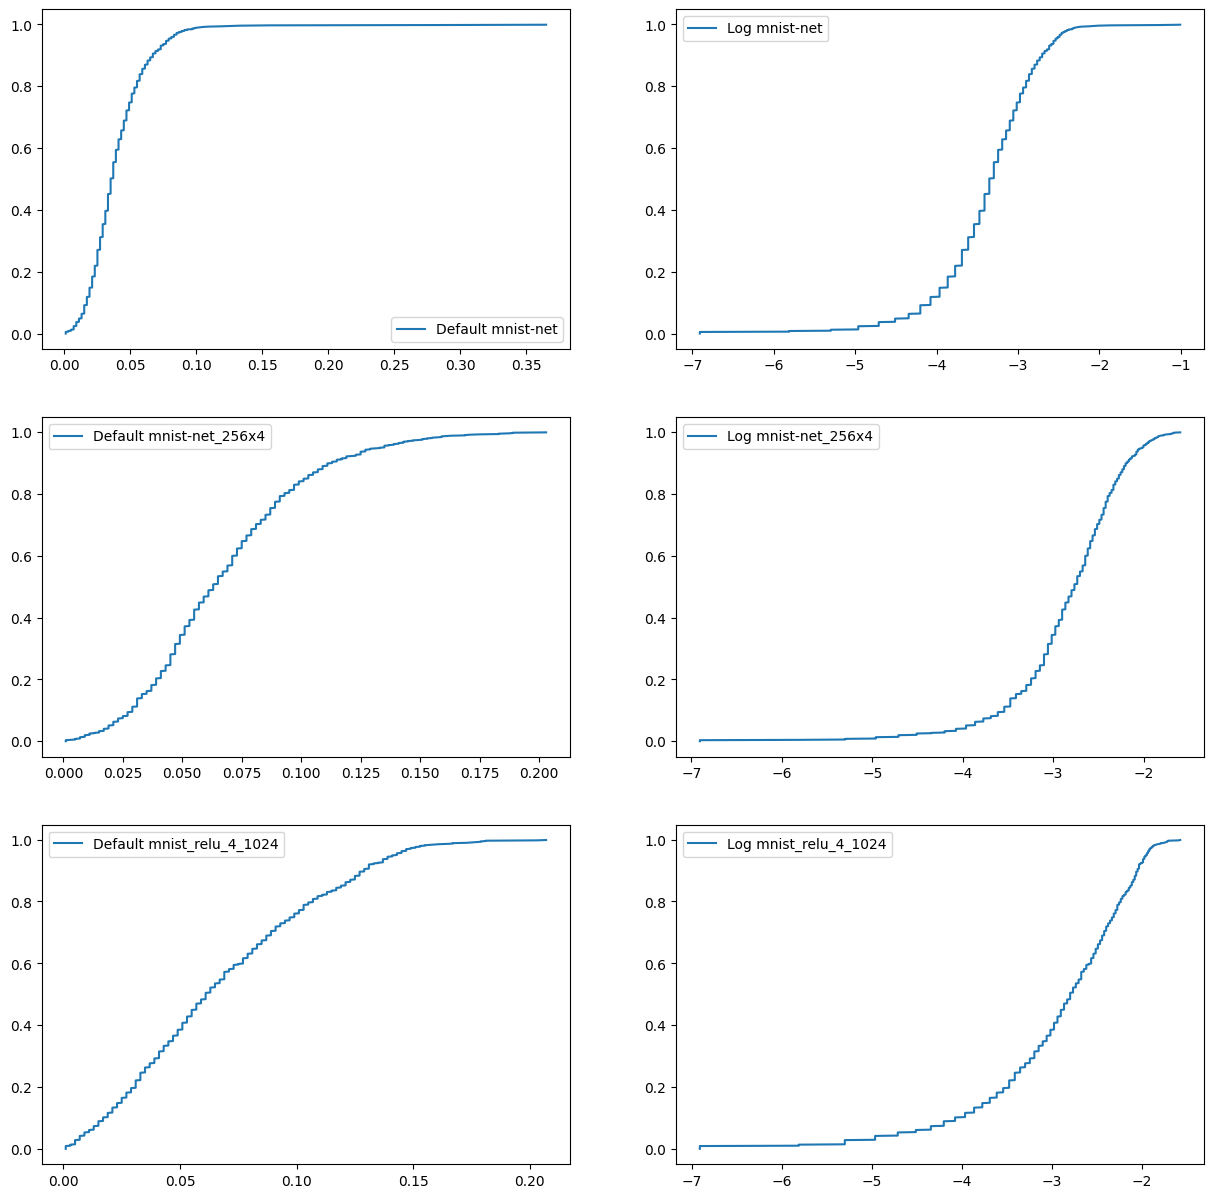

In [8]:
# Do this for all 3 networks so that the plots are on top of each other
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

for i, network in enumerate(networks):
    x1 = np.sort(crit_epsilons_network[network])
    y1 = np.arange(len(x1))/float(len(x1))
    axs[i, 0].plot(x1, y1, label='Default ' + network)

    x2 = np.sort(np.log(crit_epsilons_network[network]))
    y2 = np.arange(len(x2))/float(len(x2))
    axs[i, 1].plot(x2, y2, label='Log ' + network)
    axs[i, 0].legend()
    axs[i, 1].legend()


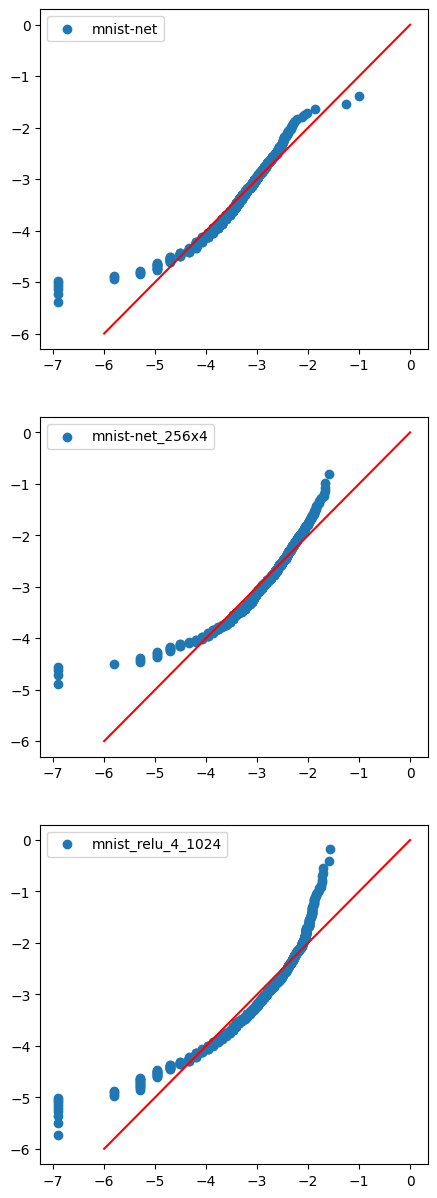

In [63]:
from scipy.stats import gamma

# QQ plots for all three networks
fig, axs = plt.subplots(3, 1, figsize=(5, 15))

for i, network in enumerate(networks):
    # we are comparing to see if it is lognormal, so assuming this we transform it to normal
    random_samples = crit_epsilons_network[network]
    random_samples = np.sort(np.log(random_samples))

    # Generate the theoretical order statistics, we do this the quick and dirty way by generating them a lot of times then taking some average
    # parameters are fitted from the data in the standard way (MLE)
    simulated_samples = np.random.normal(np.mean(random_samples), np.std(random_samples), (len(random_samples), 10000))
    simulated_samples = np.sort(simulated_samples, axis=0)
    simulated_samples = np.median(simulated_samples, axis=1) # we take median as average
    
    # confidence interval
    # we take the 2.5 and 97.5 percentiles
    lower_bound = np.percentile(simulated_samples, 2.5)
    upper_bound = np.percentile(simulated_samples, 97.5)


    axs[i].scatter(random_samples, simulated_samples, label=network)
    # plot diagonal line
    x = np.linspace(-6, 0, 100)
    axs[i].plot(x, x, color='red')
    axs[i].legend()
    
# save figure under folder Figures/QQ plots
fig.savefig('Figures/QQ plots/lognormal ' + network + '.png')

In [60]:
print(simulated_samples[:10])
print(random_samples[:10])

[-5.73079735 -5.49547496 -5.36318146 -5.27096137 -5.19711567 -5.13787831
 -5.08796176 -5.04088285 -5.00234231 -4.96735617]
[-6.90775528 -6.90775528 -6.90775528 -6.90775528 -6.90775528 -6.90775528
 -6.90775528 -6.90775528 -6.90775528 -5.80914299]


In [ ]:
# Now lets try to fit a gamma distribution to the data
fig, axs = plt.subplots(3, 1, figsize=(5, 15))

for i, network in enumerate(networks):
    y = crit_epsilons_network[network]
    

In [ ]:
# Q-Q plot
# take random samples from normal distribution
norm = np.random.lognormal(0, 1, 10000)
norm.sort()

norm2 = np.random.lognormal(50, 1000, 10000)
norm2.sort()

plt.scatter(np.log(norm), np.log(norm2))

# plot diagonal line
x = np.linspace(-5, 5, 100)
plt.plot(x, x, color='red')

In [ ]:
# split crit epsilon in things of 200 and then see the quantiles

for i in range(10):
    print(get_quantile(crit_epsilons[(i)*100:(i+1)*100], 0.05, verbose=True))

In [ ]:
get_quantile(crit_epsilons, 0.05)

In [ ]:
# sample a log normal 10000 times
log_normal = np.random.lognormal(0, 1, 10000000)

In [ ]:
# plot empirical cdf
x = np.sort(np.log(log_normal))
y = np.arange(len(x))/float(len(x))
plt.plot(x, y)
